In [ ]:
from active_critic.utils.gym_utils import (
    make_vec_env, 
    make_dummy_vec_env, 
    sample_expert_transitions_rollouts, 
    make_pomdp_rollouts, 
    make_dummy_vec_env_pomdp,
    get_avr_succ_rew_det
)
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.evaluation import evaluate_policy
import warnings
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces
from torch.nn import functional as F

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance,  get_schedule_fn

from torch.utils.data import DataLoader
from imitation.algorithms.adversarial import gail 
from imitation.util.networks import RunningNorm
from imitation.rewards.reward_nets import BasicRewardNet
from stable_baselines3.ppo import MlpPolicy
from active_critic.utils.tboard_graphs import TBoardGraphs
from active_critic.model_src.transformer import PositionalEncoding
from imitation.algorithms.adversarial.gail import GAIL
from imitation.rewards.reward_nets import BasicRewardNet
from imitation.util.networks import RunningNorm
from imitation.util.util import make_vec_env
from stable_baselines3 import PPO
import os

import copy

from active_critic.TQC.tqc import TQC
from active_critic.TQC.tqc_policy import TQCPolicyEval

def run_experiment(device):
    pass
device='cuda'
lookup_freq = 1
env, vec_expert = make_dummy_vec_env(name='pickplace', seq_len=200)
val_env, _ = make_dummy_vec_env(name='pickplace', seq_len=200)

transitions, rollouts = sample_expert_transitions_rollouts(vec_expert.predict, env, 10)
env.envs[0].reset_count = 0
pomdp_rollouts = make_pomdp_rollouts(rollouts, lookup_frq=lookup_freq, count_dim=10)
pomdp_transitions = rollout.flatten_trajectories(pomdp_rollouts)

pomdp_env, pomdp_vec_expert = make_dummy_vec_env_pomdp(name='pickplace', seq_len=200, lookup_freq=lookup_freq)
policy_kwargs = {'net_arch' : [32, 32, 32]}
tqc_learner = TQC(policy='MlpPolicy', env=pomdp_env, device=device, policy_kwargs=policy_kwargs)

    

In [ ]:
tqc_learner = TQC(policy='MlpPolicy', env=pomdp_env, device=device, policy_kwargs=policy_kwargs)

bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=pomdp_transitions,
    device=device,
    policy=tqc_learner.policy)
th.save(bc_trainer.policy.state_dict(), 'test')
policy = copy.deepcopy(bc_trainer.policy)

In [ ]:
def evaluate_learner(env_tag, logname, save_path, seq_len, n_demonstrations, bc_epochs, n_samples, device, learner:TQC=None):
    lookup_freq = 1000
    env, vec_expert = make_dummy_vec_env(name=env_tag, seq_len=seq_len)
    val_env, _ = make_dummy_vec_env(name=env_tag, seq_len=seq_len)
    transitions, rollouts = sample_expert_transitions_rollouts(vec_expert.predict, val_env, n_demonstrations)

    pomdp_rollouts = make_pomdp_rollouts(rollouts, lookup_frq=lookup_freq, count_dim=10)
    pomdp_transitions = rollout.flatten_trajectories(pomdp_rollouts)

    if learner is None:
        bc_learner = bc.BC(
            observation_space=env.observation_space,
            action_space=env.action_space,
            demonstrations=pomdp_transitions,
            device=device)
    else:
        bc_learner = bc.BC(
            observation_space=env.observation_space,
            action_space=env.action_space,
            demonstrations=pomdp_transitions,
            device=device,
            policy=learner.policy)

    pomdp_env_val, pomdp_vec_expert = make_dummy_vec_env_pomdp(name=env_tag, seq_len=seq_len, lookup_freq=lookup_freq)

    tboard = TBoardGraphs(logname=logname + ' BC' , data_path='/data/bing/hendrik/gboard/')
    best_succes_rate = -1
    best_model = None
    runs_per_epoch = 20
    for i in range(bc_epochs):
        bc_learner.train(n_epochs=runs_per_epoch)
        success, rews = get_avr_succ_rew_det(env=pomdp_env_val, learner=bc_learner.policy, epsiodes=200)
        success_rate = success.mean()
        tboard.addValidationScalar('Reward', value=th.tensor(rews.mean()), stepid=i)
        tboard.addValidationScalar('Success Rate', value=th.tensor(success_rate), stepid=i)
        if success_rate > best_succes_rate:
            best_succes_rate = success_rate
            th.save(bc_learner.policy.state_dict(), save_path + logname + ' BC best')
            print(save_path + logname + ' BC best')
    
    if learner is not None:

        tboard = TBoardGraphs(logname=logname + str(' Reinforcement') , data_path='/data/bing/hendrik/gboard/')
        learner.policy.load_state_dict(th.load(save_path + logname + ' BC best'))
        success, rews = get_avr_succ_rew_det(env=pomdp_env_val, learner=learner.policy, epsiodes=200)
        tboard.addValidationScalar('Reloaded Success Rate', value=th.tensor(success.mean()), stepid=0)
        tboard.addValidationScalar('Reloaded Reward', value=th.tensor(rews.mean()), stepid=0)

        tboard.addValidationScalar('Reward', value=th.tensor(rews.mean()), stepid=pomdp_env.envs[0].reset_count)
        tboard.addValidationScalar('Success Rate', value=th.tensor(success_rate), stepid=pomdp_env.envs[0].reset_count)

        while learner.env.envs[0].reset_count <= n_samples:
            print('before learn')
            learner.learn(2000)
            print('after learn')
            print(learner.env.envs[0].reset_count)
            success, rews = get_avr_succ_rew_det(env=pomdp_env_val, learner=learner.policy, epsiodes=200)
            success_rate = success.mean()
            tboard.addValidationScalar('Reward', value=th.tensor(rews.mean()), stepid=pomdp_env.envs[0].reset_count)
            tboard.addValidationScalar('Success Rate', value=th.tensor(success_rate), stepid=pomdp_env.envs[0].reset_count)

In [ ]:
device = 'cuda'
env_tag = 'pickplace'
seq_len = 200
pomdp_env, pomdp_vec_expert = make_dummy_vec_env_pomdp(name=env_tag, seq_len=seq_len, lookup_freq=lookup_freq)
tqc_learner = TQC(policy='MlpPolicy', env=pomdp_env, device=device)
evaluate_learner(env_tag, 'TQC 10', save_path='/data/bing/hendrik/Evaluate Baseline/', seq_len=seq_len, n_demonstrations=10, bc_epochs=400, n_samples=400, device='cuda', learner=tqc_learner)

In [ ]:
from imitation.algorithms.adversarial.gail import GAIL
from imitation.rewards.reward_nets import BasicRewardNet
from imitation.util.networks import RunningNorm
from imitation.util.util import make_vec_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv

import gym


venv = make_vec_env("seals/CartPole-v0", n_envs=8, rng=rng)
learner = PPO(
    env=venv,
    policy=MlpPolicy,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
)
reward_net = BasicRewardNet(
    venv.observation_space, venv.action_space, normalize_input_layer=RunningNorm
)
gail_trainer = GAIL(
    demonstrations=rollouts,
    demo_batch_size=1024,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round=4,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net,
)

In [32]:
def evaluate_GAIL(env_tag, logname, seq_len, n_demonstrations, n_samples, learner, pomdp_env, save_path, bc_epochs, bc_logname):
    lookup_freq = 1000
    env, vec_expert = make_dummy_vec_env(name=env_tag, seq_len=seq_len)
    val_env, _ = make_dummy_vec_env(name=env_tag, seq_len=seq_len)
    transitions, rollouts = sample_expert_transitions_rollouts(vec_expert.predict, val_env, n_demonstrations)

    pomdp_rollouts = make_pomdp_rollouts(rollouts, lookup_frq=lookup_freq, count_dim=10)
    pomdp_transitions = rollout.flatten_trajectories(pomdp_rollouts)

    pomdp_env_val, pomdp_vec_expert = make_dummy_vec_env_pomdp(name=env_tag, seq_len=seq_len, lookup_freq=lookup_freq)
    if (not os.path.isfile(save_path + bc_logname + ' BC best')):
        print('BC')
        bc_learner = bc.BC(
            observation_space=env.observation_space,
            action_space=env.action_space,
            demonstrations=pomdp_transitions,
            device=device,
            policy=learner.policy)
        
        tboard = TBoardGraphs(logname=logname + ' BC' , data_path='/data/bing/hendrik/gboard/')
        best_succes_rate = -1
        best_model = None
        runs_per_epoch = 20
        for i in range(bc_epochs):
            bc_learner.train(n_epochs=runs_per_epoch)
            success, rews = get_avr_succ_rew_det(env=pomdp_env_val, learner=bc_learner.policy, epsiodes=200)
            success_rate = success.mean()
            tboard.addValidationScalar('Reward', value=th.tensor(rews.mean()), stepid=i)
            tboard.addValidationScalar('Success Rate', value=th.tensor(success_rate), stepid=i)
            if success_rate > best_succes_rate:
                best_succes_rate = success_rate
                th.save(bc_learner.policy.state_dict(), save_path + bc_logname + ' BC best')
                print(save_path + logname + ' BC best')
    else:
        print('skipping BC')

    reward_net = BasicRewardNet(
        pomdp_env.observation_space, pomdp_env.action_space, normalize_input_layer=RunningNorm
    )

    learner.policy.load_state_dict(th.load(save_path + bc_logname + ' BC best'))

    gail_trainer = GAIL(
        demonstrations=pomdp_transitions,
        demo_batch_size=min(1024, len(transitions)),
        gen_replay_buffer_capacity=2048,
        n_disc_updates_per_round=4,
        venv=pomdp_env,
        gen_algo=learner,
        reward_net=reward_net,
    ) 

    tboard = TBoardGraphs(logname=logname , data_path=save_path)
    success, rews = get_avr_succ_rew_det(env=pomdp_env_val, learner=learner.policy, epsiodes=200)
    success_rate = success.mean()
    tboard.addValidationScalar('Reward', value=th.tensor(rews.mean()), stepid=min(learner.env.envs[0].reset_count, n_samples))
    tboard.addValidationScalar('Success Rate', value=th.tensor(success_rate), stepid=min(learner.env.envs[0].reset_count, n_samples))

    while learner.env.envs[0].reset_count <= n_samples:
        print(f'nsamples: {n_samples}')
        print(f'learner.env.envs[0].reset_count')
        print('before learn')
        gail_trainer.train(5000)
        print('after learn')
        print(learner.env.envs[0].reset_count)
        success, rews = get_avr_succ_rew_det(env=pomdp_env_val, learner=learner.policy, epsiodes=200)
        success_rate = success.mean()
        tboard.addValidationScalar('Reward', value=th.tensor(rews.mean()), stepid=min(learner.env.envs[0].reset_count, n_samples))
        tboard.addValidationScalar('Success Rate', value=th.tensor(success_rate), stepid=min(learner.env.envs[0].reset_count, n_samples))

In [33]:
def evaluate_GAIL_PPO(device):
    env_tag = 'pickplace'
    lookup_freq = 1000
    lr = 1e-3
    seq_lens = [50, 100, 200]
    for i in range(5):
        for seq_len in seq_lens:
            demonstrations = 6
            for j in range(4):
                demonstrations += 2
                pomdp_env, pomdp_vec_expert = make_dummy_vec_env_pomdp(name=env_tag, seq_len=seq_len, lookup_freq=lookup_freq)
                learner = PPO(
                        env=pomdp_env,
                        policy=MlpPolicy,
                        batch_size=64,
                        ent_coef=0.0,
                        learning_rate=lr,
                        n_epochs=10,
                        device=device
                    )
                logname = f'GAIL + PPO lr: {lr}, Demonstrations: {demonstrations}, seq_len: {seq_len}'
                bc_logname = f'GAIL + PPO Demonstrations: {demonstrations}, seq_len: {seq_len}'
                evaluate_GAIL(
                    env_tag, 
                    logname, 
                    seq_len, 
                    demonstrations, 
                    400, 
                    learner, 
                    pomdp_env, 
                    save_path='/data/bing/hendrik/Evaluate Baseline/',
                    bc_epochs = 400,
                    bc_logname = bc_logname)
        lr = lr * 0.6

In [34]:
def evaluate_GAIL_TQC(device):
    env_tag = 'pickplace'
    lookup_freq = 1000
    lr = 1e-3
    seq_lens = [50, 100, 200]
    for i in range(5):
        for seq_len in seq_lens:
            demonstrations = 6
            for j in range(4):
                demonstrations += 2
                pomdp_env, pomdp_vec_expert = make_dummy_vec_env_pomdp(name=env_tag, seq_len=seq_len, lookup_freq=lookup_freq)
                learner = TQC(policy='MlpPolicy', env=pomdp_env, device=device, learning_rate=lr)

                logname = f'GAIL + TQC lr: {lr}, Demonstrations: {demonstrations}, seq_len: {seq_len}'
                evaluate_GAIL(env_tag, logname, seq_len, demonstrations, 400, learner, pomdp_env, save_path='/data/bing/hendrik/Evaluate Baseline/')
        lr = lr * 0.6

/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/metaworld/policies/policy.py:41: UserWarning: Constant(s) may be too high. Environments clip response to [-1, 1]
  warnings.warn('Constant(s) may be too high. Environments clip response to [-1, 1]')
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00568 |
|    entropy        | 5.68     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 207      |
|    loss           | 5.07     |
|    neglogp        | 5.08     |
|    prob_true_act  | 0.0115   |
|    samples_so_far | 32       |
--------------------------------


240batch [00:00, 248.77batch/s]


/data/bing/hendrik/Evaluate Baseline/GAIL + PPO lr: 0.001, Demonstrations: 8, seq_len: 50 BC best


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.0047  |
|    entropy        | 4.7      |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 218      |
|    loss           | 3.15     |
|    neglogp        | 3.16     |
|    prob_true_act  | 0.0476   |
|    samples_so_far | 32       |
--------------------------------


240batch [00:00, 247.44batch/s]


KeyboardInterrupt: 

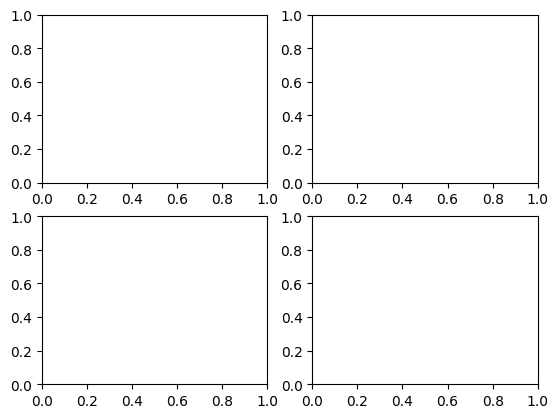

In [35]:
evaluate_GAIL_PPO(device='cuda')

In [ ]:
evaluate_GAIL_TQC(device='cuda')